# How this works:

Combine data from
1. Daily stock movement (download with rapidapi)
2. Insider trades scraped from openinsider
3. Articles from yahoo finance, graded as either positive neutral or negative through a huggingface NLP model aggregated into a daily sentiment

Todo: Merge it all together and feed into an LSTM model

# Initialize

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import assets.config as config
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

/Users/ryanhermes/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
ticker = 'NOW'

### 1. Daily Info

In [16]:
if os.path.exists(f'data/{ticker}_daily.csv'):
    print('File exists')
else:
    # Define the URL and headers
    url = f"https://yahoo-finance127.p.rapidapi.com/historic/{ticker}/1d/730d"
    headers = {
        "x-rapidapi-key": "dfbe7c0a1fmshe393d06dc43c773p13ef07jsnc9ba1900f6ce",
        "x-rapidapi-host": "yahoo-finance127.p.rapidapi.com"
    }

    # Make the request
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Extract JSON data
        data = response.json()

        # Extract data
        timestamps = data['timestamp']
        close_prices = data['indicators']['quote'][0]['close']
        volumes = data['indicators']['quote'][0]['volume']

        # Convert timestamps to "yyyy-mm-dd" format
        dates = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in timestamps]

        # Prepare data for CSV
        csv_data = list(zip(dates, close_prices, volumes))

        # Define CSV file path
        csv_file_path = f'data/{ticker}_daily.csv'

        # Write to CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Date', 'Close', 'Volume'])  # Header row
            writer.writerows(csv_data)

        print(f"Data written to {csv_file_path}")
    else:
        print("Error:", response.status_code)

Data written to data/NFLX_daily.csv


In [4]:
# Alphavantage implementation

# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={config.alphavantage_apikey}'
# r = requests.get(url)
# data = r.json()

# header = list(data['Time Series (Daily)']['2024-05-14'].keys())
# header.insert(0, 'Date')

# # Writing to CSV
# with open(f'data/{ticker}_daily.csv', 'w', newline='') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=header)
    
#     writer.writeheader()
    
#     for date, values in data['Time Series (Daily)'].items():
#         row = {'Date': date}
#         row.update(values)
#         writer.writerow(row)


### 2. Insider Trades

In [5]:
url = f"http://openinsider.com/screener?s={ticker}&o=&pl=&ph=&ll=&lh=&fd=730&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=1000&page=1"

# Request the webpage
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

time.sleep(1)

# Find the table
table = soup.find('table', class_='tinytable')

if table:
    # Extract table rows
    rows = table.find_all('tr')

    # Create an empty list to store the data
    data = []

    # Loop through rows and extract data
    for row in rows[1:]:  # Skip the header row
        cells = row.find_all('td')
        insider_info = {
            'Trade Date': cells[2].get_text(strip=True),
            'Value': cells[11].get_text(strip=True)
        }
        data.append(insider_info)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    # Remove dollar sign and comma from 'Value' column and convert to numeric type
    df['Value'] = df['Value'].str.replace('$', '').str.replace(',', '').astype(float)

    # Group the data by 'Trade Date' and aggregate the values
    df_merged = df.groupby('Trade Date').agg({'Value': 'sum'}).reset_index()

    # Save DataFrame to CSV
    df_merged.to_csv(f'data/{ticker}_insider_trades.csv', index=False)
    print('Insider trades data saved')

else:
    print('No table found')

Insider trades data saved


/var/folders/b7/3syr39bd24n_5m711ln6vz800000gn/T/ipykernel_23828/485494802.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Value'] = df['Value'].str.replace('$', '').str.replace(',', '').astype(float)


### 3. Articles

Get articles

In [6]:
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

article_links = []

def get_yahoo_articles():
    driver.get(f"https://finance.yahoo.com/quote/{ticker}/news")

    # Scroll down the page multiple times to load more articles
    for _ in range(5): # scroll x times
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)

    page_source = driver.page_source
    driver.quit()
    soup = BeautifulSoup(page_source, 'html.parser')

    articles = soup.find_all("li", class_="stream-item svelte-7rcxn")

    for article in articles:
        link = article.find("a").get("href")
        if '/news/' in link: article_links.append(link)
        
get_yahoo_articles()

print(article_links)

['https://finance.yahoo.com/news/gtn-nflx-better-value-stock-154008851.html', 'https://finance.yahoo.com/news/growth-investor-1-stock-could-134511131.html', 'https://finance.yahoo.com/news/netflix-inc-nasdaq-nflx-best-131816353.html', 'https://finance.yahoo.com/news/investors-heavily-search-netflix-inc-130015457.html', 'https://finance.yahoo.com/news/analyst-reboots-trade-desk-stock-113700202.html', 'https://finance.yahoo.com/news/netflix-uses-squid-game-playbook-020000892.html', 'https://finance.yahoo.com/news/netflix-open-2-massive-venues-211648412.html', 'https://finance.yahoo.com/news/disney-ceo-bob-igers-successor-could-be-revealed-in-2024-says-his-close-adviser-201011400.html', 'https://finance.yahoo.com/news/netflix-wants-chill-store-fan-193435764.html', 'https://finance.yahoo.com/news/zacks-analyst-blog-highlights-visa-134700476.html', 'https://finance.yahoo.com/news/insider-sale-co-ceo-gregory-230051040.html', 'https://finance.yahoo.com/news/netflix-nflx-rises-higher-market-21

In [7]:
# article_links = ['https://finance.yahoo.com/news/snowflake-inc-snow-rises-higher-214519243.html']

In [8]:
import time
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import re
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

# Function to measure runtime
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__} took {end_time - start_time:.2f} seconds")
        return result
    return wrapper

@measure_time
def scrape_yahoo_finance(url):
    # Define the path to the ChromeDriver executable directly
    chromedriver_path = 'assets/chromedriver'  # Adjust to 'assets/chromedriver.exe' on Windows if necessary

    # Set up Selenium WebDriver
    service = Service(chromedriver_path)
    options = webdriver.ChromeOptions()
    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')
    options.add_argument('--headless')  # Run in headless mode
    options.add_argument('--disable-gpu')  # Disable GPU acceleration
    options.add_argument('--no-sandbox')  # Bypass OS security model
    options.add_argument('--disable-dev-shm-usage')  # Overcome limited resource problems
    # Disable images to speed up page load
    prefs = {"profile.managed_default_content_settings.images": 2}
    options.add_experimental_option("prefs", prefs)

    driver = webdriver.Chrome(service=service, options=options)
    driver.get(url)

    try:
        # Wait until the element is present
        WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.ID, "caas-lead-header-undefined"))
        )

        # Get page source and parse with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Get header
        header_element = soup.find(id="caas-lead-header-undefined")
        header = header_element.get_text().strip() if header_element else "N/A"

        # Get body
        article_elements = soup.find_all(class_="caas-body")
        body = ""
        for element in article_elements:
            body += element.get_text().strip() + "\n"

        # Get date
        date_text = soup.find_all(class_="caas-attr-time-style")[0].get_text().strip()
        date = re.search(r'(\w{3}, \w{3} \d{1,2}, \d{4})', date_text)
        date = datetime.strptime(date.group(), "%a, %b %d, %Y").strftime("%Y-%m-%d") if date else "N/A"

        return header, body, date
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None
    finally:
        driver.quit()

def analyze(text):
    # Summarizer
    summarizer_api_url = "https://api-inference.huggingface.co/models/sshleifer/distilbart-cnn-12-6"
    summarizer_headers = {"Authorization": f"Bearer {config.huggingface_apikey}"}
    summarizer_output = requests.post(summarizer_api_url, headers=summarizer_headers, json={"inputs": text}).json()
    text = summarizer_output[0]['summary_text']

    # Sentimentizer
    sentimentizer_api_url = "https://api-inference.huggingface.co/models/ProsusAI/finbert"
    sentimentizer_headers = {"Authorization": f"Bearer {config.huggingface_apikey}"}
    sentimentizer_output = requests.post(sentimentizer_api_url, headers=sentimentizer_headers, json={"inputs": text}).json()

    most_likely_label, max_score = None, 0
    for sentiment in sentimentizer_output[0]:
        label, score = sentiment['label'], sentiment['score']
        if score > max_score:
            most_likely_label, max_score = label, score
    if most_likely_label == 'positive':
        sentiment = 1
    elif most_likely_label == 'neutral':
        sentiment = 0
    else:
        sentiment = -1

    return sentiment, summarizer_output, sentimentizer_output

# Parallel scraping function
def scrape_multiple_articles(urls):
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(scrape_yahoo_finance, urls))
    return results

# Main engine
articledata = []
company_table = pd.read_csv('assets/companies.csv')
short_name, company_name = company_table.loc[company_table['ticker'] == ticker]['short name'].values[0], company_table.loc[company_table['ticker'] == ticker]['company name'].values[0]

# Scrape articles
results = scrape_multiple_articles(article_links)
for i, (head, body, date) in enumerate(results):
    if head is None or body is None or date is None:
        continue
    
    if ticker in head or short_name in head or company_name in head:
        pass
    else:
        continue

    try:
        sentiment, summarizer_output, sentimentizer_output = analyze(body)
    except Exception as sentiment_error:
        print(f"Failed to analyze sentiment for article '{article_links[i]}': {sentiment_error.__class__.__name__}: {str(sentiment_error)} \n")
        continue

    articledata.append({'Date': date, 'Sentiment': sentiment})
    print(f"Iteration {i}: {date}, '{head}'\n- {article_links[i]}\n- Summarizer output: {summarizer_output[0]['summary_text']}\n- Sentimentizer output: {sentimentizer_output[0][0]['label']} ({round(sentimentizer_output[0][0]['score'], 2)})\n")

df = pd.DataFrame(articledata)

df['Negative_Count'] = (df['Sentiment'] == -1).astype(int)
df['Neutral_Count'] = (df['Sentiment'] == 0).astype(int)
df['Positive_Count'] = (df['Sentiment'] == 1).astype(int)
df['Negative_Count'] *= -1

# Group by date and sum the counts
df_grouped = df.groupby('Date').agg({'Negative_Count': 'sum', 'Neutral_Count': 'sum', 'Positive_Count': 'sum'}).reset_index()
df_grouped['Total_Count'] = df_grouped['Negative_Count'] + df_grouped['Positive_Count']

df_grouped.to_csv(f'data/{ticker}_sentiment.csv', index=False)

print("Success")


Function scrape_yahoo_finance took 15.10 seconds
Function scrape_yahoo_finance took 15.19 seconds
Function scrape_yahoo_finance took 9.30 seconds
Function scrape_yahoo_finance took 9.82 seconds
Function scrape_yahoo_finance took 10.13 seconds
Function scrape_yahoo_finance took 85.47 seconds
Function scrape_yahoo_finance took 88.24 seconds
Function scrape_yahoo_finance took 88.37 seconds
Function scrape_yahoo_finance took 82.69 seconds
Function scrape_yahoo_finance took 89.32 seconds
Function scrape_yahoo_finance took 10.63 seconds
Function scrape_yahoo_finance took 10.23 seconds
Function scrape_yahoo_finance took 84.75 seconds
Function scrape_yahoo_finance took 85.18 seconds
Function scrape_yahoo_finance took 91.39 seconds
Function scrape_yahoo_finance took 89.38 seconds
Function scrape_yahoo_finance took 83.43 seconds
Function scrape_yahoo_finance took 15.13 seconds
Function scrape_yahoo_finance took 85.49 seconds
Function scrape_yahoo_finance took 85.77 seconds
Function scrape_yahoo_

In [9]:
def scrape_yahoo_finance(url):
    response = requests.get(url)
    print(response)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Get header
        header_element = soup.find(id="caas-lead-header-undefined")
        header = header_element.get_text().strip()

        # Get body
        article_elements = soup.find_all(class_="caas-body")
        body = ""
        for element in article_elements: body += element.get_text().strip() + "\n"

        # Get date
        date_text = soup.find_all(class_="caas-attr-time-style")[0].get_text().strip()
        date = re.search(r'(\w{3}, \w{3} \d{1,2}, \d{4})', date_text)
        date = datetime.strptime(date.group(), "%a, %b %d, %Y").strftime("%Y-%m-%d")

        return header, body, date
    else:
        print("Failed to retrieve the webpage. Status code:", response.status_code)

def analyze(text):
    # Summarizer
    summarizer_api_url = "https://api-inference.huggingface.co/models/sshleifer/distilbart-cnn-12-6"
    summarizer_headers = {f"Authorization": f"Bearer {config.huggingface_apikey}"}
    summarizer_output = requests.post(summarizer_api_url, headers=summarizer_headers, json={"inputs": text}).json()
    text = summarizer_output[0]['summary_text']

    # Sentimentizer
    sentimentizer_api_url = "https://api-inference.huggingface.co/models/ProsusAI/finbert"

    # ----- New model below, might use this since finbert has problems
    # https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis???????

    sentimentizer_headers = {"Authorization": f"Bearer {config.huggingface_apikey}"}
    sentimentizer_output = requests.post(sentimentizer_api_url, headers=sentimentizer_headers, json={"inputs": text}).json()

    most_likely_label, max_score = None, 0
    for sentiment in sentimentizer_output[0]:
        label, score = sentiment['label'], sentiment['score']
        if score > max_score: most_likely_label, max_score = label, score
    if most_likely_label == 'positive': sentiment = 1
    elif most_likely_label == 'neutral': sentiment = 0
    else: sentiment = -1

    return sentiment, summarizer_output, sentimentizer_output

# Main engine
articledata = []
company_table = pd.read_csv('assets/companies.csv')
short_name, company_name = company_table.loc[company_table['ticker'] == ticker]['short name'].values[0], company_table.loc[company_table['ticker'] == ticker]['company name'].values[0]

for i, article in enumerate(article_links):
    try: 
        head, body, date = scrape_yahoo_finance(article)
        if ticker in head or short_name in head or company_name in head: pass
        else: continue
    except Exception as scrape_error:
        print(f"Failed to scrape article '{article}': {scrape_error.__class__.__name__}: {str(scrape_error)} \n")

        continue

    try: 
        sentiment, summarizer_output, sentimentizer_output = analyze(body)
    except Exception as sentiment_error:
        print(f"Failed to analyze sentiment for article '{article}': {sentiment_error.__class__.__name__}: {str(sentiment_error)} \n")
        continue

    articledata.append({'Date': date, 'Sentiment': sentiment})
    print(f"Iteration {i}: {date}, '{head}'\n- {article}\n- Summarizer output:{summarizer_output[0]['summary_text']}\n- Sentimentizer output: {sentimentizer_output[0][0]['label']} ({round(sentimentizer_output[0][0]['score'], 2)})\n")

df = pd.DataFrame(articledata)

df['Negative_Count'] = (df['Sentiment'] == -1).astype(int)
df['Neutral_Count'] = (df['Sentiment'] == 0).astype(int)
df['Positive_Count'] = (df['Sentiment'] == 1).astype(int)
df['Negative_Count'] *= -1

# Group by date and sum the counts
df_grouped = df.groupby('Date').agg({'Negative_Count': 'sum', 'Neutral_Count': 'sum', 'Positive_Count': 'sum'}).reset_index()
df_grouped['Total_Count'] = df_grouped['Negative_Count'] + df_grouped['Positive_Count']

df_grouped.to_csv(f'data/{ticker}_sentiment.csv', index=False)

print("Success")

<Response [200]>
Iteration 0: 2024-06-19, 'GTN or NFLX: Which Is the Better Value Stock Right Now?'
- https://finance.yahoo.com/news/gtn-nflx-better-value-stock-154008851.html
- Summarizer output: Gray Television (GTN) and Netflix (NFLX) are sporting Zacks Ranks of #1 (Strong Buy) and #3 (Hold), respectively, respectively, right now . GTN earns a Value grade of A, while NFLX has been given a value grade of D (A) in our Style Scores system .
- Sentimentizer output: neutral (0.84)

<Response [200]>
<Response [200]>
Iteration 2: 2024-06-19, 'Is Netflix Inc (NASDAQ:NFLX) the Best Undervalued Stock to Buy in 2024?'
- https://finance.yahoo.com/news/netflix-inc-nasdaq-nflx-best-131816353.html
- Summarizer output: Venu Krishna, Head of U.S. Equity Strategy & Global Equity Linked Strategies at Barclays, recently shared a basket of stocks he recommends offsetting the risks that come from market concentration in big tech stocks . Krishna said he applied “liquidity filters” on the whole market to 

# Merge

In [20]:
historical = pd.read_csv(f'data/{ticker}_daily.csv')
insider = pd.read_csv(f'data/{ticker}_insider_trades.csv')
news = pd.read_csv(f'data/{ticker}_sentiment.csv')

newdata = pd.merge(historical, insider, how='left', left_on='Date', right_on='Trade Date')
newdata = pd.merge(newdata, news, how='left', on='Date')
newdata['Date'] = pd.to_datetime(newdata['Date'])

# Alphavantage technique: newdata.rename(columns={'4. close': 'Close', '5. volume': 'Volume', 'Value': 'Insider_Trades'}, inplace=True)
# Alphavantage technique: newdata = newdata.drop(columns=['1. open', '2. high', '3. low', 'Trade Date'])
newdata.rename(columns={'Value': 'Insider_Trades'}, inplace=True)
newdata = newdata.fillna(0)
newdata['Close_Delta'] = newdata['Close'] - newdata['Close'].shift(1)
# newdata['Total_Count_Delta'] = newdata['Total_Count'] - newdata['Total_Count'].shift(1)
# newdata['Insider_Trades'] = newdata['Insider_Trades'].fillna(0)

newdata = newdata.drop(columns=['Trade Date'])

newdata.to_csv(f'data/{ticker}_merged.csv', index=True, index_label='Time')

print(newdata.head)

<bound method NDFrame.head of           Date       Close   Volume  Insider_Trades  Negative_Count  \
0   2021-07-26  516.489990  2254500             0.0             0.0   
1   2021-07-27  518.909973  2759000             0.0             0.0   
2   2021-07-28  519.299988  2390500             0.0             0.0   
3   2021-07-29  514.250000  1736000             0.0             0.0   
4   2021-07-30  517.570007  2537100             0.0             0.0   
..         ...         ...      ...             ...             ...   
725 2024-06-12  650.059998  2094400             0.0             0.0   
726 2024-06-13  653.260010  1863600             0.0             0.0   
727 2024-06-14  669.380005  4447100      -3228525.0            -4.0   
728 2024-06-17  675.830017  3631200             0.0            -1.0   
729 2024-06-18  685.669983  2943800             0.0            -1.0   

     Neutral_Count  Positive_Count  Total_Count  Close_Delta  
0              0.0             0.0          0.0       

# Visualize

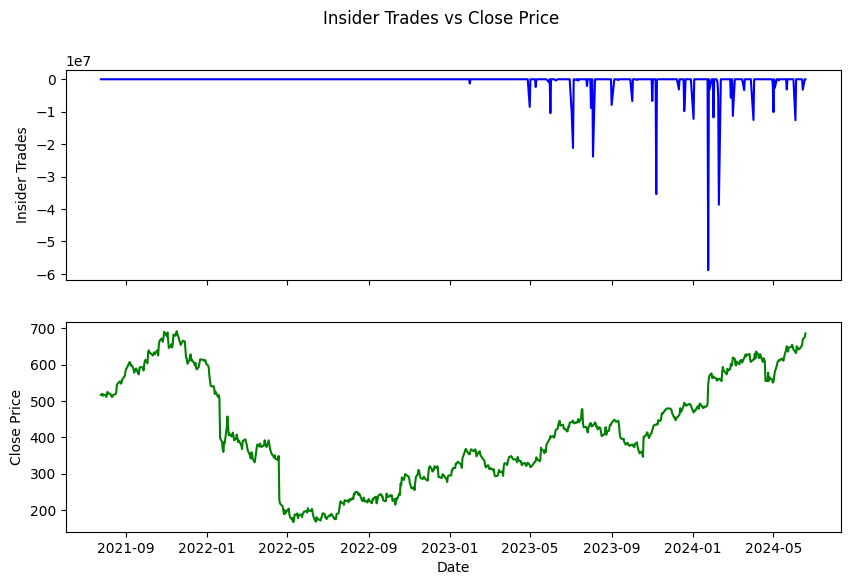

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(newdata['Date'], newdata['Insider_Trades'], color='blue')
ax2.plot(newdata['Date'], newdata['Close'], color='green')

ax1.set_ylabel('Insider Trades')
ax2.set_ylabel('Close Price')
ax2.set_xlabel('Date')
plt.suptitle('Insider Trades vs Close Price')

plt.show()

35


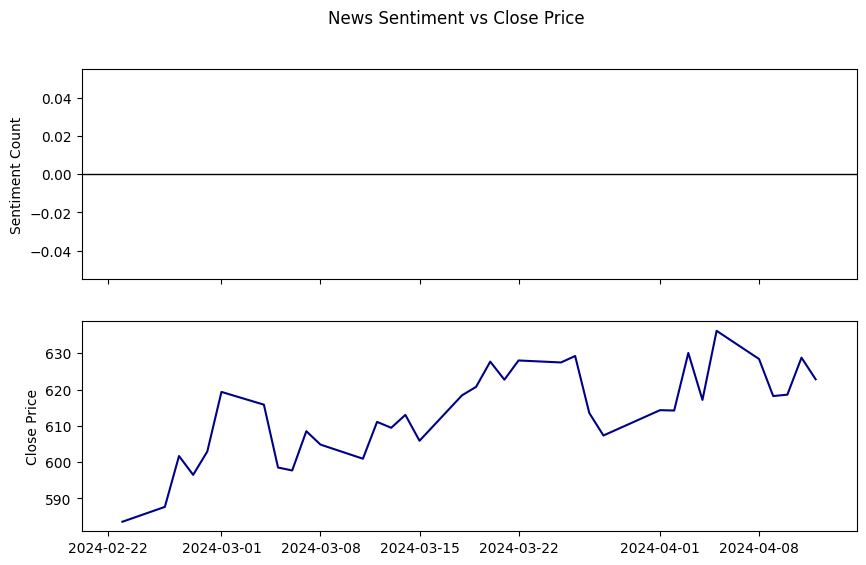

In [18]:
data = pd.read_csv(f'data/{ticker}_merged.csv')
data = data[-65:-30]
data['Date'] = pd.to_datetime(data['Date'])

print(len((data)))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.axhline(0, color='Black', linewidth=1)
ax1.bar(data['Date'], data['Total_Count'], color='blue', align='center', label='Overall Sentiment')
ax2.plot(data['Date'], data['Close'], color='darkblue', label='Close Price')

plt.suptitle('News Sentiment vs Close Price')
ax1.set_ylabel('Sentiment Count')
ax2.set_ylabel('Close Price')

plt.show()

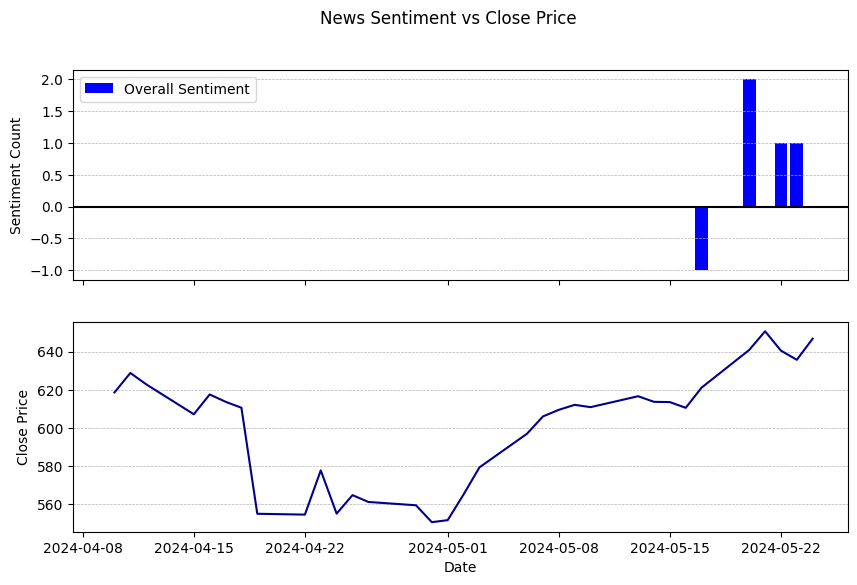

In [13]:
# print(newdata['Close'], newdata['Total_Count'])
# print(np.corrcoef(newdata['Close'], newdata['Total_Count'])[0, 1])
# print(newdata['Date'][::-1][:(int(len(news) * 1.2))])
newdata = pd.read_csv(f'data/{ticker}_merged.csv')
newdata = newdata[::-1][:int(len(news) * 1.2)]
# print(newdata['Total_Count'])
newdata['Total_Count'] = newdata['Total_Count'].shift(periods=1)
newdata['Negative_Count'] = newdata['Total_Count'].shift(periods=1)
newdata['Positive_Count'] = newdata['Total_Count'].shift(periods=1)
# print(newdata)[:5]

# Convert 'Date' column to datetime
newdata['Date'] = pd.to_datetime(newdata['Date'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ax1.bar(newdata['Date'], newdata['Negative_Count'], color='red', align='center', label='Negative Sentiment')
# ax1.bar(newdata['Date'], newdata['Positive_Count'], color='green', align='center', label='Positive Sentiment')
ax1.bar(newdata['Date'], newdata['Total_Count'], color='blue', align='center', label='Overall Sentiment')

# Add horizontal gridlines to the top chart
ax1.grid(which='major', axis='y', linestyle='--', linewidth=0.5)
ax2.grid(which='major', axis='y', linestyle='--', linewidth=0.5)
ax1.axhline(0, color='black')

# Plot Close Price
ax2.plot(newdata['Date'], newdata['Close'], color='darkblue', label='Close Price')

# Set y-axis labels
ax1.set_ylabel('Sentiment Count')
ax2.set_ylabel('Close Price')

# Set x-axis label
ax2.set_xlabel('Date')

# Add legend to ax1
ax1.legend()

# Set title for the entire plot
plt.suptitle('News Sentiment vs Close Price')

# Show plot
plt.show()

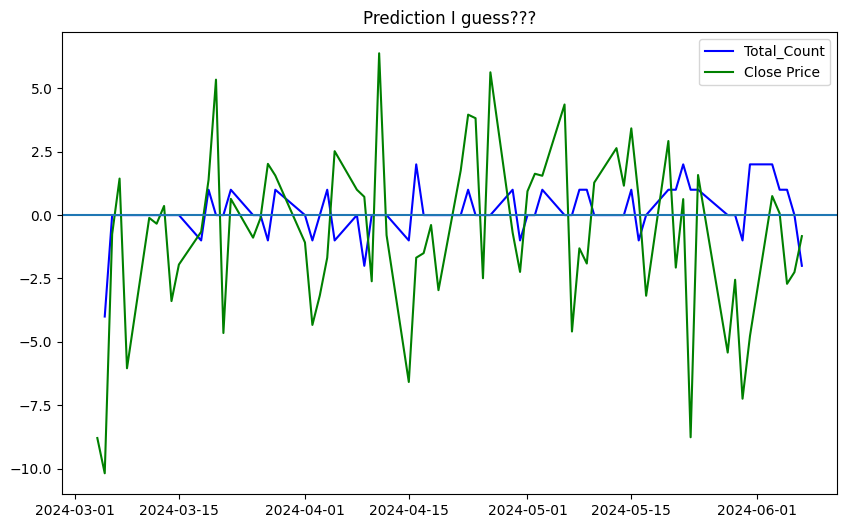

In [14]:
# Load the data
data_path = 'subset.csv'
newdata = pd.read_csv(data_path)
# print(newdata)

newdata['Date'] = pd.to_datetime(newdata['Date'])

newdata['Total_Count'] = newdata['Total_Count'].shift(1)

plt.figure(figsize=(10, 6))
plt.plot(newdata['Date'], newdata['Total_Count'], label='Total_Count', color='blue')
plt.plot(newdata['Date'], newdata['Close_Delta'], label='Close Price', color='green')
plt.axhline(0)
plt.legend()
plt.title('Prediction I guess???')
plt.show()


Jane Street if you see this hire me 🙏

Loading data from: data/NFLX_merged.csv
Data loaded successfully. First few rows:
   Time        Date       Close   Volume  Insider_Trades  Negative_Count  \
0     0  2021-07-26  516.489990  2254500             0.0             0.0   
1     1  2021-07-27  518.909973  2759000             0.0             0.0   
2     2  2021-07-28  519.299988  2390500             0.0             0.0   
3     3  2021-07-29  514.250000  1736000             0.0             0.0   
4     4  2021-07-30  517.570007  2537100             0.0             0.0   

   Neutral_Count  Positive_Count  Total_Count  Close_Delta  
0            0.0             0.0          0.0          NaN  
1            0.0             0.0          0.0     2.419983  
2            0.0             0.0          0.0     0.390015  
3            0.0             0.0          0.0    -5.049988  
4            0.0             0.0          0.0     3.320007  
Handling NaN values...
NaN values handled. First few rows after handling NaNs:
   Time        D

/var/folders/b7/3syr39bd24n_5m711ln6vz800000gn/T/ipykernel_23828/634442549.py:28: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


Epoch 1/10, Loss: 0.1377
Epoch 2/10, Loss: 0.0478
Epoch 3/10, Loss: 0.0172
Epoch 4/10, Loss: 0.0124
Epoch 5/10, Loss: 0.0103
Epoch 6/10, Loss: 0.0104
Epoch 7/10, Loss: 0.0084
Epoch 8/10, Loss: 0.0089
Epoch 9/10, Loss: 0.0068
Epoch 10/10, Loss: 0.0072
Model training completed in 2.23 seconds.
Evaluating the model...
Test Loss: 0.0060
Making predictions...
Correlation between actual and predicted close prices: 0.9418
Correlation between actual and predicted delta close prices: -0.1095


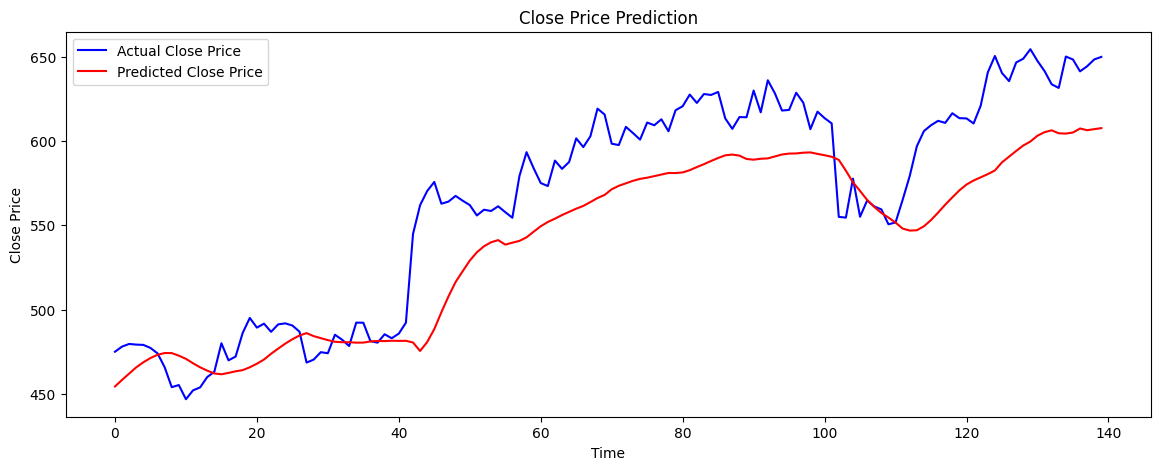

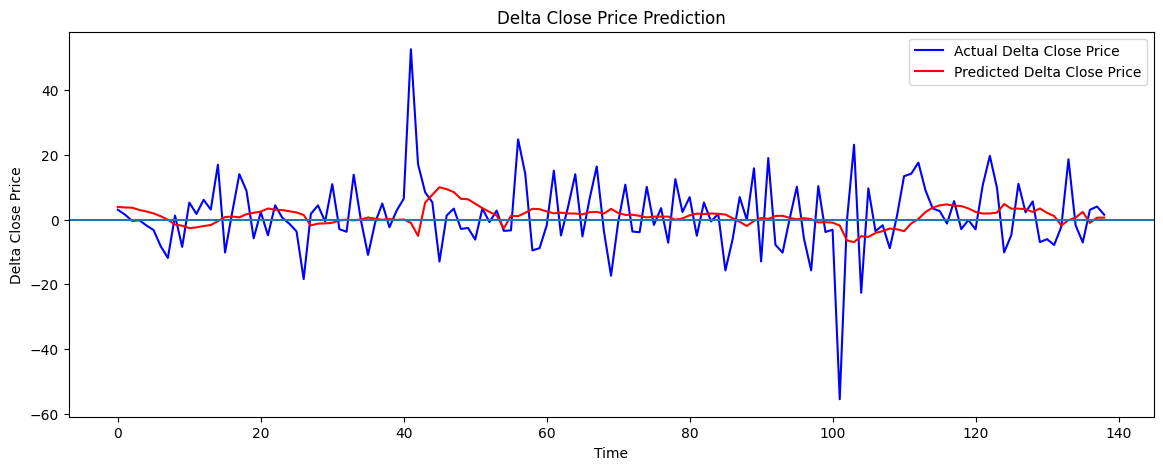

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from scipy.stats import pearsonr

# Adjustable Variables
file_path = f'data/{ticker}_merged.csv'  # File path to your dataset
sequence_length = 30  # Length of the sequence for LSTM
future_steps = 5  # Number of steps into the future to predict
epochs = 10  # Number of epochs for training
batch_size = 16  # Batch size for training
learning_rate = 0.001  # Learning rate

# Load the data
print("Loading data from:", file_path)
data = pd.read_csv(file_path)
print("Data loaded successfully. First few rows:")
print(data.head())

# Handle NaN values by imputing with the mean
print("Handling NaN values...")
data.fillna(data.mean(), inplace=True)
print("NaN values handled. First few rows after handling NaNs:")
print(data.head())

# Preprocessing
print("Preprocessing data...")
data['Date'] = data['Date'].astype(str)
data['DateTime'] = pd.to_datetime(data['Date'])
data.set_index('DateTime', inplace=True)

features = ['Volume', 'Insider_Trades', 'Total_Count', 'Time']
target = 'Close'

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features + [target]])
print("Data scaled successfully. Shape of scaled data:", scaled_data.shape)

def create_sequences(data, sequence_length, future_steps):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length - future_steps + 1):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length:i + sequence_length + future_steps, -1])  # 'Close' column
    return np.array(sequences), np.array(targets)

print("Creating sequences...")
X, y = create_sequences(scaled_data, sequence_length, future_steps)
print(f"Sequences created. Shape of X: {X.shape}, Shape of y: {y.shape}")

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, future_steps):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, future_steps)
    
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_dim = len(features) + 1
hidden_dim = 32
output_dim = 1
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, future_steps)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
print("Starting model training...")
start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

end_time = time.time()
print(f"Model training completed in {end_time - start_time:.2f} seconds.")

# Evaluate the model
print("Evaluating the model...")
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Predict the 'Close' prices
print("Making predictions...")
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())

predictions = np.concatenate(predictions)

# Inverse scale the predictions
scaled_predictions = np.zeros((predictions.shape[0], len(features) + 1))
scaled_predictions[:, -1] = predictions[:, 0]
inverse_predictions = scaler.inverse_transform(scaled_predictions)[:, -1]

# Inverse scale the true values
scaled_true = np.zeros((y_test.shape[0], len(features) + 1))
scaled_true[:, -1] = y_test[:, 0]
inverse_true = scaler.inverse_transform(scaled_true)[:, -1]

correlation, _ = pearsonr(inverse_true, inverse_predictions)
print(f'Correlation between actual and predicted close prices: {correlation:.4f}')
correlation_delta, _ = pearsonr(np.diff(inverse_true), np.diff(inverse_predictions))
print(f'Correlation between actual and predicted delta close prices: {correlation_delta:.4f}')

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(inverse_true, color='blue', label='Actual Close Price')
plt.plot(inverse_predictions, color='red', label='Predicted Close Price')
plt.title('Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot the delta (change) of predicted and actual close prices
delta_true = np.diff(inverse_true)
delta_predictions = np.diff(inverse_predictions)

plt.figure(figsize=(14, 5))
plt.plot(delta_true, color='blue', label='Actual Delta Close Price')
plt.plot(delta_predictions, color='red', label='Predicted Delta Close Price')
plt.title('Delta Close Price Prediction')
plt.axhline(0)
plt.xlabel('Time')
plt.ylabel('Delta Close Price')
plt.legend()
plt.show()
